In [1]:
# Importing all libraries
import numpy
from matplotlib import pyplot
from time import time

In [2]:
from codes.grids import regular_grid
from codes.prism import prism_tf
from codes.auxiliars import addnoise
from codes.statistical import analysis

In [45]:
# Defines number of points
nx, ny = 50, 50
# Define the area
area = (-2000., 2000., -2000., 2000.)
shape = (nx, ny)
# Creates the grid
xobs, yobs, zobs = regular_grid(area, shape, -200.)

In [82]:
# Define the elements of the prims for gravity and magnetic computation
model1 = (-250., 250., -500., 500., 100., 200., 1.28)
# Directions
inc, dec = -23., -33. # field
incs, decs = -3., 6. # source

In [83]:
# Computes the total field anomaly
tf = prism_tf(xobs, yobs, zobs, model1, inc, dec, incs, decs)

In [84]:
_ = analysis(tf, 'nT')

Minimum:    -43.9500 nT
Maximum:    24.0268 nT
Mean value: -0.3445 nT
Variation:  67.9768 nT


In [85]:
# Adding noise
tf = addnoise(tf, 4., 0.1)

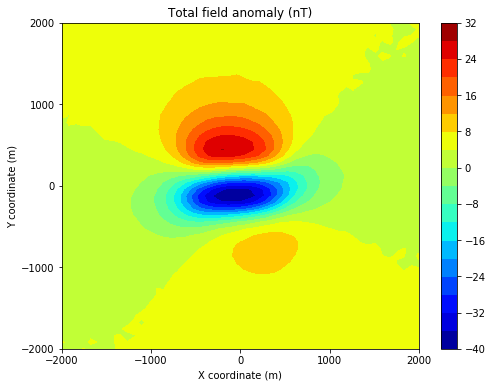

In [86]:
# Plotting the result
pyplot.figure(figsize=(8, 6))
pyplot.contourf(yobs.reshape(shape), xobs.reshape(shape), tf.reshape(shape), 
                20, cmap = pyplot.cm.jet)
pyplot.title('Total field anomaly (nT)')
pyplot.xlabel('X coordinate (m)')
pyplot.ylabel('Y coordinate (m)')
pyplot.xticks(numpy.linspace(yobs.min(), yobs.max(), 5))
pyplot.yticks(numpy.linspace(xobs.min(), xobs.max(), 5))
pyplot.colorbar()
pyplot.show()

In [74]:
from codes.equivalentlayer import layer, mat_mag_tfa

In [10]:
# Layer informations
area_layer = (-2000., 2000., -2000., 2000.)
shape_layer = (15, 15)
level = 500.

In [11]:
# Create the layer
eqlayer = layer(area_layer, shape_layer, level)

In [12]:
data = [xobs, yobs, zobs, tf]

In [13]:
def rtp_layer(datasets, datashape, layermodel, layershape, incf, decf, inceql = None, deceql = None):
    '''
    It returns the reduce to Pole data by using the equivalent layer technique. This functions 
    must receives all data as a list with all positions for x, y and z, and also the potential 
    data. It receives the shape of the data, the model as an equivalent layer and the values of
    inclination and declination as well, for both field and depth sources.    
    
    Inputs:
    datasets - numpy list - x, y and z positions and total field data
    datashape - tuple - shape of the input data
    layermodel - list - values for created equivalent layer
    layershape - tuple - shape of the equivalent layer
    incf - float - inclination of the geomagnetic field
    decf - float - declination of the geomagnetic field
    inceql - float - inclination of all depth sources
    deceql - float - declination of all depth sources
    
    Output:
    rtp - numpy array - reduce to Pole data
    
    '''
    
    # Verify the depth of the equivalent layer
    if level <= 0.:
        raise ValueError('Layer depth must be a positive value!')
    
    # Define the type of magnetization
    if inceql == None or deceql == None:
        inceql = incf
        deceql = decf
        
    # Datasets = [xobs, yobs, zobs, totalfield]
    xp = datasets[0]
    yp = datasets[1]
    zp = datasets[2]
    tf = datasets[3]
    
    # Define the number of observations and depth sources
    N = datashape[0]*datashape[1]
    M = layershape[0]*layershape[1]
    
    # Computes the sensitivity matrix
    matA = mat_mag_tfa(xp, yp, zp, layermodel, incf, decf, inceql, deceql)
    
    # Case1: Overdetermined - Number of observations are greater or equal than the number of depth sources
    if N >= M: 
        mu = 1.e-6
        I = numpy.identity(M)
        trace = numpy.trace(matA.T.dot(matA))/M
        vec = numpy.linalg.solve(numpy.dot(matA.T, matA) + mu*trace*I, numpy.dot(matA.T, tf))
    # Case2: Underterminated - Number of observations are less than the number of depth sources
    else:
        mu = 1.e-6
        I = numpy.identity(N)
        trace = numpy.trace(matA.T.dot(matA))/N
        aux = numpy.linalg.solve(numpy.dot(matA, matA.T) + mu*trace*I, tf)
        vec = numpy.dot(matA.T, aux)
        
    # Calculates the predicted total field anomaly data
    tf_pred = numpy.dot(matA, vec)
    
    # Create the new matrix for reduction to Pole
    mat_rtp = mat_mag_tfa(xp, yp, zp, layermodel, 90., 0., 90., 0.)
    # Calculates the reduction to Pole
    rtp = numpy.dot(mat_rtp, vec)    
    return rtp.reshape(datashape)

In [14]:
# Importing filtering functions
from codes.filtering import reduction
from codes.derivative import totalgrad, zderiv
# Importing the correlation function
from codes.statistical import cccoef

In [19]:
# Create the grid
# for the fourier trans:
inclination1 = numpy.linspace(-90.0, -10.0, 81)
inclination2= numpy.linspace(10., 90., 81)
declination = numpy.linspace(-180.0, 180.0, 361)

# for the layer:
inc3 = numpy.linspace(-10.0,10.0, 11)
dec3 = numpy.linspace(-180.0, 180.0, 73)

In [20]:
D1, I1 = numpy.meshgrid(declination, inclination1)
D2, I2 = numpy.meshgrid(declination, inclination2)
D3, I3 = numpy.meshgrid(dec3, inc3)

In [21]:
res1 = numpy.zeros_like(D1)
res2 = numpy.zeros_like(D2)
res3 = numpy.zeros_like(D3)

In [22]:
xobs = xobs.reshape(shape)
yobs = yobs.reshape(shape)
tf = tf.reshape(shape)

In [23]:
initial = time()
for k2, d in enumerate(declination):
    for k1, i in enumerate(inclination1):
        rtp = reduction(xobs, yobs, tf, inc, dec, i, d)
        tga = totalgrad(xobs, yobs, rtp)
        vga = zderiv(xobs, yobs, rtp)
        res1[k1,k2] = cccoef(tga, vga)        
final = time()

codes/auxiliars.py:207: RuntimeWarning: invalid value encountered in divide
  theta = z + ((x*u + y*v)/k)*1j


In [24]:
print 'Cross correlation for positive range'
print 'Computation time (sec): %.3f' % (final-initial)

Cross correlation for positive range
Computation time (sec): 36.572


In [25]:
initial = time()
for k2, d in enumerate(declination):
    for k1, i in enumerate(inclination2):    
        rtp = reduction(xobs, yobs, tf, inc, dec, i, d)
        tga = totalgrad(xobs, yobs, rtp)
        vga = zderiv(xobs, yobs, rtp)
        res2[k1,k2] = cccoef(tga, vga)        
final = time()

In [26]:
print 'Cross correlation for negative range'
print 'Computation time (sec): %.3f' % (final-initial)

Cross correlation for negative range
Computation time (sec): 35.053


In [28]:
initial = time()
for k2, d in enumerate(dec3):
    for k1, i in enumerate(inc3):    
        rtp = rtp_layer(data, shape, eqlayer, shape_layer, inc, dec, i, d)
        tga = totalgrad(xobs, yobs, rtp)
        vga = zderiv(xobs, yobs, rtp)
        res3[k1,k2] = cccoef(tga, vga)        
final = time()

In [29]:
print 'Cross correlation by equivalent layer'
print 'Computation time (sec): %.3f' % (final-initial)

Cross correlation by equivalent layer
Computation time (sec): 602.961


In [30]:
# Analysing the positive coefficients
print 'Simple cross-correlation:'
_ = analysis(res1, 'no unit')

Simple cross-correlation:
Minimum:    -0.4787 no unit
Maximum:    0.5499 no unit
Mean value: 0.2608 no unit
Variation:  1.0286 no unit


In [31]:
# Analysing the negative coefficients
print 'Simple anti-correlation:'
_ = analysis(res2, 'no unit')

Simple anti-correlation:
Minimum:    -0.5499 no unit
Maximum:    0.4787 no unit
Mean value: -0.2609 no unit
Variation:  1.0286 no unit


In [32]:
# Analysing the positive coefficients
print 'Correlation (equivalent layer):'
_ = analysis(res3, 'no unit')

Correlation (equivalent layer):
Minimum:    -0.5175 no unit
Maximum:    0.5175 no unit
Mean value: -0.0051 no unit
Variation:  1.0349 no unit


In [34]:
# Busca do par de inclinacao e declinacao positivos
imax1, jmax1 = numpy.where(res1 == res1.max())
imin1, jmin1 = numpy.where(res1 == res1.min())
incmax1 = float(I1[imax1, jmax1])
decmax1 = float(D1[imax1, jmax1])
incmin1 = float(I1[imin1, jmin1])
decmin1 = float(D1[imin1, jmin1])
print 'Verify the computed correlation:'
print '(I,D) for maximum coefficient'
print 'Inclination:', incmax1
print 'Declination:', decmax1
print
print '(I,D) for minimum coefficient:'
print 'Inclination:', incmin1
print 'Declination:', decmin1

Verify the computed correlation:
(I,D) for maximum coefficient
Inclination: -21.0
Declination: 79.0

(I,D) for minimum coefficient:
Inclination: -10.0
Declination: -89.0


In [35]:
# Busca do par de inclinacao e declinacao positivos
imax2, jmax2 = numpy.where(res2 == res2.max())
imin2, jmin2 = numpy.where(res2 == res2.min())
incmax2 = float(I2[imax2, jmax2])
decmax2 = float(D2[imax2, jmax2])
incmin2 = float(I2[imin2, jmin2])
decmin2 = float(D2[imin2, jmin2])
print 'Verify the computed anticorrelation:'
print '(I,D) for maximum coefficient'
print 'Inclination:', incmax2
print 'Declination:', decmax2
print
print '(I,D) for minimum coefficient:'
print 'Inclination:', incmin2
print 'Declination:', decmin2

Verify the computed anticorrelation:
(I,D) for maximum coefficient
Inclination: 10.0
Declination: 91.0

(I,D) for minimum coefficient:
Inclination: 21.0
Declination: -101.0


In [36]:
# Busca do par de inclinacao e declinacao positivos
imax3, jmax3 = numpy.where(res3 == res3.max())
imin3, jmin3 = numpy.where(res3 == res3.min())
incmax3 = float(I3[imax3, jmax3])
decmax3 = float(D3[imax3, jmax3])
incmin3 = float(I3[imin3, jmin3])
decmin3 = float(D3[imin3, jmin3])
print 'Verify correlation by equivalent layer:'
print '(I,D) for maximum coefficient'
print 'Inclination:', incmax3
print 'Declination:', decmax3
print
print '(I,D) for minimum coefficient:'
print 'Inclination:', incmin3
print 'Declination:', decmin3

Verify correlation by equivalent layer:
(I,D) for maximum coefficient
Inclination: -2.0
Declination: 0.0

(I,D) for minimum coefficient:
Inclination: 2.0
Declination: 180.0


/home/nielsendelimar/anaconda2/lib/python2.7/site-packages/matplotlib/contour.py:960: UserWarning: The following kwargs were not used by contour: 'linestyle'
  s)


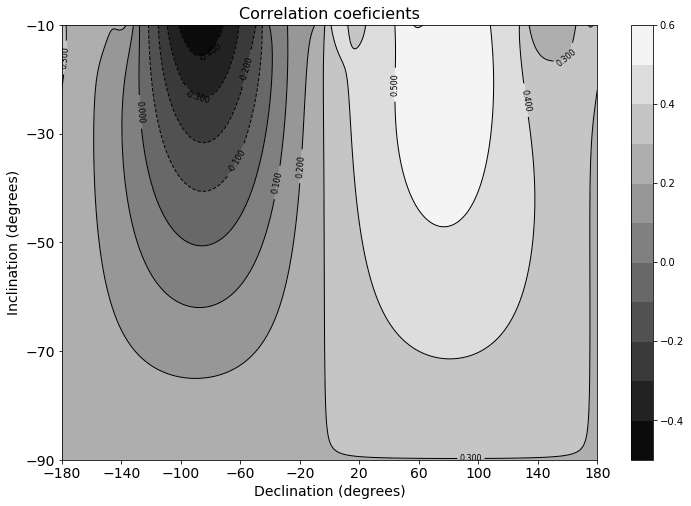

In [37]:
# Plotting the correlation results
pyplot.figure(figsize=(12, 8))
fig1 = pyplot.contour(D1, I1, res1, 10, colors = 'k', linestyle = 'solid', linewidths = 1)
pyplot.contourf(D1, I1, res1,10, cmap = pyplot.cm.gray)
pyplot.clabel(fig1, fontsize = 8)
pyplot.rcParams['contour.negative_linestyle'] = 'solid'
pyplot.title('Correlation coeficients', fontsize = 16)
pyplot.xlabel('Declination (degrees)', fontsize = 14)
pyplot.ylabel('Inclination (degrees)', fontsize = 14)
pyplot.xticks(numpy.linspace(D1.min(), D1.max(), 10), fontsize = 14)
pyplot.yticks(numpy.linspace(I1.min(), I1.max(), 5), fontsize = 14)
#pyplot.legend(loc = 'upper center', fontsize = 'large')
pyplot.colorbar()
pyplot.show()

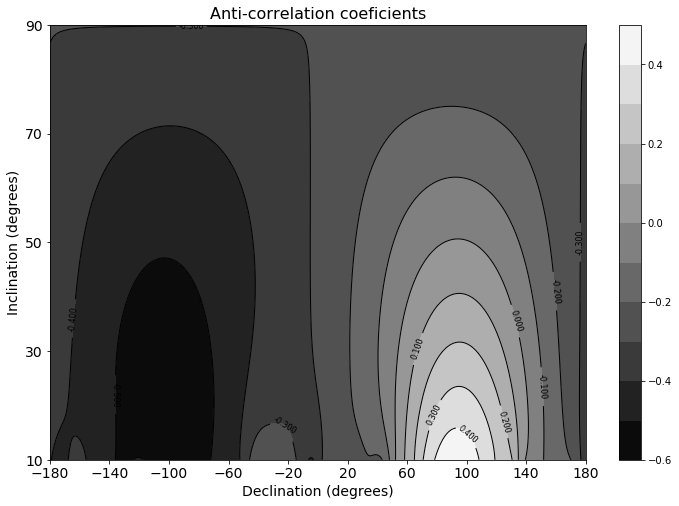

In [38]:
# Plotting the correlation results
pyplot.figure(figsize=(12, 8))
fig2 = pyplot.contour(D2, I2, res2, 10, colors = 'k', linestyle = 'solid', linewidths = 1)
pyplot.contourf(D2, I2, res2,10, cmap = pyplot.cm.gray)
pyplot.clabel(fig2, fontsize = 8)
pyplot.rcParams['contour.negative_linestyle'] = 'solid'
pyplot.title('Anti-correlation coeficients', fontsize = 16)
pyplot.xlabel('Declination (degrees)', fontsize = 14)
pyplot.ylabel('Inclination (degrees)', fontsize = 14)
pyplot.xticks(numpy.linspace(D2.min(), D2.max(), 10), fontsize = 14)
pyplot.yticks(numpy.linspace(I2.min(), I2.max(), 5), fontsize = 14)
#pyplot.legend(loc = 'upper center', fontsize = 'large')
pyplot.colorbar()
pyplot.show()

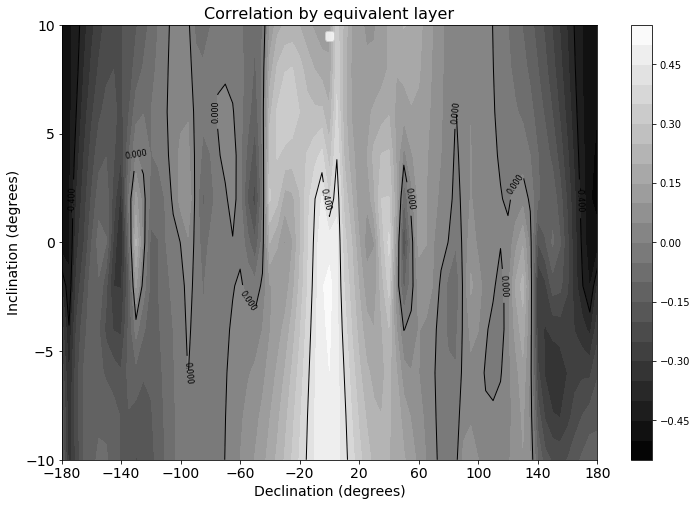

In [41]:
# Plotting the correlation results
pyplot.figure(figsize=(12, 8))
fig3 = pyplot.contour(D3, I3, res3, 2, colors = 'k', linestyle = 'solid', linewidths = 1)
pyplot.contourf(D3, I3, res3, 20, cmap = pyplot.cm.gray)
pyplot.clabel(fig3, fontsize = 8)
pyplot.rcParams['contour.negative_linestyle'] = 'solid'
pyplot.title('Correlation by equivalent layer', fontsize = 16)
pyplot.xlabel('Declination (degrees)', fontsize = 14)
pyplot.ylabel('Inclination (degrees)', fontsize = 14)
pyplot.xticks(numpy.linspace(D3.min(), D3.max(), 10), fontsize = 14)
pyplot.yticks(numpy.linspace(I3.min(), I3.max(), 5), fontsize = 14)
pyplot.legend(loc = 'upper center', fontsize = 'large')
pyplot.colorbar()
pyplot.show()